# Fine Tuning Roberta for Sentiment Analysis





In [ ]:
!pip install transformers
!pip install comet_ml

In [2]:
def set_experiment(api_key, project_name, workspace):
    experiment = Experiment(
    api_key=api_key,
    project_name=project_name,
    workspace=workspace
)
    
    return experiment

In [ ]:
import comet_ml
from comet_ml import Experiment

api_key = xxx
project_name = xxx
workspace = xxx

experiment = set_experiment(api_key, project_name, workspace)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy

import tqdm
import torch
import transformers
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer

In [5]:
import regex as re

In [6]:
def log_parameters(experiment, hyper_params):
    experiment.log_parameter("train_batch_size", hyper_params['batch_size'])
    experiment.log_parameter("test_batch_size", hyper_params['batch_size'])

    experiment.log_parameter("Learning Rate", hyper_params['lr'])
    experiment.log_parameter("general_epochs", hyper_params['epochs'])
    experiment.log_parameter("lr_decay", hyper_params['lr_decay'])
    experiment.log_parameter("max_len", hyper_params['max_len'])

In [7]:
X_train = pd.read_csv('train2.csv', header=0)
X_dev = pd.read_csv('dev2.csv', header=0)
X_test = pd.read_csv('test2.csv', header=0)

In [8]:
X_train['Text'] = X_train["Text"].str.lower()
X_dev['Text'] = X_dev["Text"].str.lower()
X_test['Text'] =X_test["Text"].str.lower()

In [9]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    per_pattern = re.compile(r'@[^\s]+')
    return per_pattern.sub(r'', url_pattern.sub(r'', text))

X_train['Text'] = [remove_urls(i) for i in X_train['Text']]
X_dev['Text'] = [remove_urls(i) for i in X_dev['Text']]
X_test['Text'] = [remove_urls(i) for i in X_test['Text']]

<a id='section03'></a>
### Preparing the Dataset and Dataloader

In [ ]:
parameters = { 'max_len'    : 256,
               'batch_size' : 32,
               'epochs'     : 15,
               'lr'         : 2e-5,
               'lr_decay'   : 0.2
             }

from transformers import AutoTokenizer, AutoModelForPreTraining

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

model = AutoModelForPreTraining.from_pretrained("cointegrated/rubert-tiny2")

#tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment', truncation=True, do_lower_case=True)
device = 'cuda' if cuda.is_available() else 'cpu'

In [11]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.Text
        self.targets = dataframe.Class
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [12]:
train_set = CustomDataset(X_train, tokenizer, parameters['max_len'])
val_set = CustomDataset(X_dev, tokenizer, parameters['max_len'])
test_set = CustomDataset(X_test, tokenizer, parameters['max_len'])

In [13]:
train_params = {'batch_size': parameters['batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': parameters['batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': parameters['batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning


In [14]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = AutoModelForPreTraining.from_pretrained("cointegrated/rubert-tiny2")
        self.pre_classifier = torch.nn.Linear(83828, 256)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(256, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooler = output_1[0][:, 0, :]
        #pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [15]:
log_parameters(experiment, parameters)

In [16]:
model = RobertaClass()
model.to(device)

experiment.set_model_graph(model, True)

<a id='section05'></a>
### Fine Tuning the Model

In [17]:
from torch.optim.lr_scheduler import StepLR

In [18]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=parameters['lr'], eps=1e-8)
lr_scheduler = StepLR(optimizer, step_size=4, 
                      gamma=parameters['lr_decay'], verbose=True)

Adjusting learning rate of group 0 to 2.0000e-05.


In [19]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [20]:
def train(model, criterion, optimizer, train_dl, val_dl, epochs, experiment, lr_scheduler: StepLR=None):
    
    train_losses = []
    val_losses = []
    
    best_model_params = deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}\n',
              f'{"--------------------" * 4}')
        
        tr_loss, n_correct, nb_tr_steps, nb_tr_examples = 0, 0, 0, 0
        tr_accuracy = 0.0
        
        model.train()
        
        for step, data in enumerate(train_dl):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            optimizer.zero_grad()
            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, targets)
            
            tr_loss += loss.item() 
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)
            
            loss.backward()
            optimizer.step()

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)

            if (step % 100 == 0 and step != 0) or (step == len(train_dl) - 1):
                # Calculate time elapsed for 20 batches
                print(f"{epoch + 1:^7} | {step:^7} |")

            
        train_loss = tr_loss/nb_tr_steps
        train_losses.append(train_loss)
        lr_scheduler.step() 
        tr_accuracy = (n_correct*100)/nb_tr_examples 
        experiment.log_metric('loss_train', train_loss)

        model.eval() 
        
        vl_loss, n_correct, nb_tr_steps, nb_tr_examples = 0, 0, 0, 0 
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for data in val_dl:
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.long)

                outputs = model(ids, mask, token_type_ids).squeeze()
                loss = criterion(outputs, targets)

                vl_loss += loss.item() 
                big_val, big_idx = torch.max(outputs.data, dim=1)
                n_correct += calcuate_accuracy(big_idx, targets)

                all_preds += big_idx.tolist()
                all_labels += targets.tolist()

                nb_tr_steps += 1
                nb_tr_examples += targets.size(0)
                
        
        val_loss = vl_loss/nb_tr_steps
        accuracy = (n_correct*100)/nb_tr_examples 
        experiment.log_metric('loss_val', val_loss)

        b_accuracy = balanced_accuracy_score(all_labels, all_preds)
        print('Balanced_accuracy know: ', b_accuracy)
        experiment.log_metric('loss_b_accuracy', b_accuracy)

        val_losses.append(val_loss)
        print(f'Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f} \t  Train Accuracy: {tr_accuracy:.4f} \t Val Accuracy: {accuracy:.4f}\n')
        
        if b_accuracy > best_accuracy:
            best_accuracy = b_accuracy
            best_model_params = deepcopy(model.state_dict())
            
            output_model_file = f'second_robert_sentiment_{round(b_accuracy, 5)}.bin'

            model_to_save = model
            torch.save(model_to_save, output_model_file)
            
    print('Finished Training and the best accuracy is: {:.4f}'.format(best_accuracy))
    return train_losses, val_losses, best_model_params, best_accuracy

In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [22]:
train_losses, val_losses, best_model_params, best_accuracy = train(
                                                                 model, 
                                                                 loss_function, 
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 val_loader, 
                                                                 parameters['epochs'], 
                                                                 experiment,
                                                                 lr_scheduler)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   1    |   100   |
   1    |   200   |
   1    |   300   |
   1    |   320   |
Adjusting learning rate of group 0 to 2.0000e-05.
Balanced_accuracy know:  0.7554647091316634
Train Loss: 1.0669 	 Val Loss: 0.5935 	  Train Accuracy: 62.5512 	 Val Accuracy: 75.5460

Epoch 2/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   2    |   100   |
   2    |   200   |
   2    |   300   |
   2    |   320   |
Adjusting learning rate of group 0 to 2.0000e-05.
Balanced_accuracy know:  0.7804086719531068
Train Loss: 0.5942 	 Val Loss: 0.5629 	  Train Accuracy: 76.0874 	 Val Accuracy: 78.0421

Epoch 3/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   3    |   100   |
   3    |   200   |
   3    |   300   |
   3    |   320   |
Adjusting learning rate of group 0 to 2.0000e-05.
Balanced_accuracy know:  0.7753212722151462
Train Loss: 0.5131 	 Val Loss: 0.5323 	  Train Accuracy: 79.5787 	 Val Accuracy: 77.5351

Epoch 4/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   4    |   100   |
   4    |   200   |
   4    |   300   |
   4    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.7870518737645571
Train Loss: 0.4576 	 Val Loss: 0.5479 	  Train Accuracy: 82.0948 	 Val Accuracy: 78.7051

Epoch 5/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   5    |   100   |
   5    |   200   |
   5    |   300   |
   5    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.7831340646698713
Train Loss: 0.3835 	 Val Loss: 0.5532 	  Train Accuracy: 84.5426 	 Val Accuracy: 78.3151

Epoch 6/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   6    |   100   |
   6    |   200   |
   6    |   300   |
   6    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.7842940685045949
Train Loss: 0.3589 	 Val Loss: 0.5850 	  Train Accuracy: 85.7031 	 Val Accuracy: 78.4321

Epoch 7/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   7    |   100   |
   7    |   200   |
   7    |   300   |
   7    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.786244755787465
Train Loss: 0.3484 	 Val Loss: 0.6174 	  Train Accuracy: 86.4346 	 Val Accuracy: 78.6271

Epoch 8/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   8    |   100   |
   8    |   200   |
   8    |   300   |
   8    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.7854627461184839
Train Loss: 0.3364 	 Val Loss: 0.5914 	  Train Accuracy: 86.7466 	 Val Accuracy: 78.5491

Epoch 9/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   9    |   100   |
   9    |   200   |
   9    |   300   |
   9    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.782732331740097
Train Loss: 0.3231 	 Val Loss: 0.6107 	  Train Accuracy: 87.2343 	 Val Accuracy: 78.2761

Epoch 10/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  10    |   100   |
  10    |   200   |
  10    |   300   |
  10    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.7842936119899019
Train Loss: 0.3177 	 Val Loss: 0.6141 	  Train Accuracy: 87.3123 	 Val Accuracy: 78.4321

Epoch 11/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  11    |   100   |
  11    |   200   |
  11    |   300   |
  11    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.7854627461184839
Train Loss: 0.3138 	 Val Loss: 0.6260 	  Train Accuracy: 87.9267 	 Val Accuracy: 78.5491

Epoch 12/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  12    |   100   |
  12    |   200   |
  12    |   300   |
  12    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.784293155475209
Train Loss: 0.3095 	 Val Loss: 0.6345 	  Train Accuracy: 87.8877 	 Val Accuracy: 78.4321

Epoch 13/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  13    |   100   |
  13    |   200   |
  13    |   300   |
  13    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.7835125153503065
Train Loss: 0.3039 	 Val Loss: 0.6575 	  Train Accuracy: 88.1705 	 Val Accuracy: 78.3541

Epoch 14/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  14    |   100   |
  14    |   200   |
  14    |   300   |
  14    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.7846834755376602
Train Loss: 0.3067 	 Val Loss: 0.6253 	  Train Accuracy: 88.0534 	 Val Accuracy: 78.4711

Epoch 15/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  15    |   100   |
  15    |   200   |
  15    |   300   |
  15    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.7846834755376602
Train Loss: 0.3077 	 Val Loss: 0.6264 	  Train Accuracy: 87.8877 	 Val Accuracy: 78.4711

Finished Training and the best accuracy is: 0.7871


<a id='section06'></a>
### Validating the Model


In [23]:
def get_predicts(model, loader):
    
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    all_preds, all_labels = [], []
    
    
    with torch.no_grad():
        for _, data in (enumerate(loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            b_labels = data['targets'].to(device, dtype = torch.long)

            logits = model(ids, mask, token_type_ids)
            preds = torch.argmax(logits, dim=1).flatten()

            all_preds += preds.tolist()
            all_labels += b_labels.tolist()

    
    return all_preds, all_labels



In [26]:
# model = RobertaClass()
model = torch.load('/content/second_robert_sentiment_0.78705.bin')

model.eval()
None

In [ ]:
y_pred_test, y_test = get_predicts(model, test_loader)
y_pred_train, y_train = get_predicts(model, train_loader)
y_pred_val, y_val = get_predicts(model, val_loader)

In [28]:
def statistic(y_pred_test, y_test, y_pred_train, y_train,
             t1, t2):
    score_table = pd.DataFrame(columns=(t1, t2))

    b_train = balanced_accuracy_score(y_train, y_pred_train)
    b_test = balanced_accuracy_score(y_test, y_pred_test)
    score_table.loc['balanced_accuracy_score', :] = (b_train, b_test)

    a_train = accuracy_score(y_train, y_pred_train)
    a_test = accuracy_score(y_test, y_pred_test)
    score_table.loc['accuracy_score', :] = (a_train, a_test)

    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    score_table.loc['f1 weighted', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='micro')
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    score_table.loc['f1 micro', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    score_table.loc['f1 macro', :] = (f1_train, f1_test)

    return score_table

In [29]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
def cm_plot(y_test, y_pred, y_type):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title(f'Confusion Matrix of {y_type}')

    return plt.show()

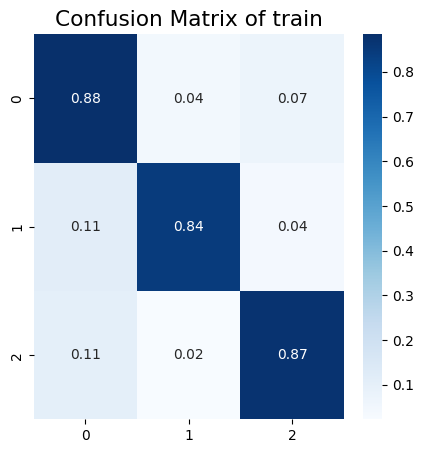

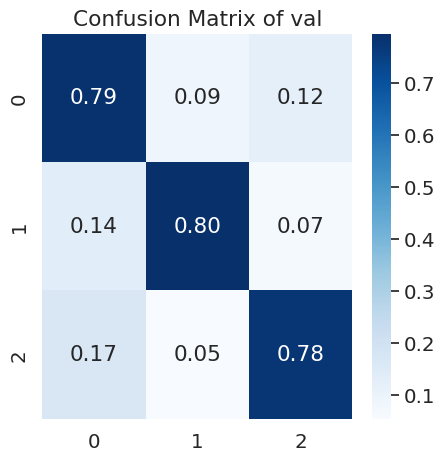

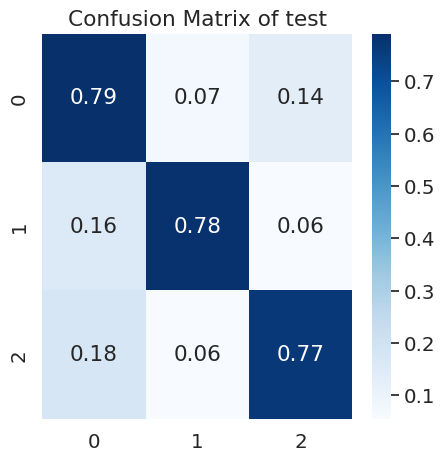

In [31]:
cm_plot(y_train, y_pred_train, 'train')
cm_plot(y_val, y_pred_val, 'val')
cm_plot(y_test, y_pred_test, 'test')

In [32]:
statistic(y_pred_test, y_test, y_pred_train, y_train, 'train', 'test')

,train,test
balanced_accuracy_score,0.866296,0.780652
accuracy_score,0.866296,0.780655
f1 weighted,0.867025,0.781999
f1 micro,0.866296,0.780655
f1 macro,0.867025,0.782011


In [33]:
statistic(y_pred_train, y_train, y_pred_val, y_val, 'dev', 'train')

,dev,train
balanced_accuracy_score,0.787052,0.866296
accuracy_score,0.787051,0.866296
f1 weighted,0.78796,0.867025
f1 micro,0.787051,0.866296
f1 macro,0.787946,0.867025


In [24]:
from google.colab import files
from google.colab import drive

drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [25]:
!cp second_robert_sentiment_0.78705.bin xxx